In [22]:
import multiannealing
from copy import deepcopy
from datetime import datetime
import dill
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from multiannealing.score.ChemLiabilities import ChemLiabilities
from multiannealing.score.TepitopesMatrix import TepitopesMatrix
from multiannealing.score.EVHmodel import EVHmodel
from multiannealing.score.MultiScore import MultiScore
from multiannealing.score.Basic import TargetSeqEffect, SeqDist
from multiannealing.anneal.MultiAnnealer import MultiAnnealer

# Input

In [2]:
IdeS = '''
VTSVWTKGVTPPANFTQGEDVFHAPYVANQGWYDITKTFNGKDDLLCGAATAG
NMLHWWFDQNKDQIKRYLEEHPEKQKINFNGEQMFDVKEAIDTKNHQLDSKLF
EYFKEKAFPYLSTKHLGVFPDHVIDMFINGYRLSLTNHGPTPVKEGSKDPRGG
IFDAVFTRGDQSKLLTSRHDFKEKNLKEISDLIKKELTEGKALGLSHTYANVR
INHVINLWGADFDSNGNLKAIYVTDSDSNASIGMKKYFVGVNSAGKVAISAKE
IKEDNIGAQVLGLFTLSTGQDSWNQTN
'''.replace('\n','').upper()

In [3]:
JOBID = 'IdeS_48-391_demo'
PDBNAME = 'data/2AU1.pdb'

job_data = {
    'jobid' : JOBID,
    'target_seq' : IdeS,
    'index1' : 48,
    'pdbfile' : PDBNAME
}

# Load models

In [4]:
scorefxn_files = [
 '../../data/netmhciipan/IdeS_48-391_demo_netMHCIIpan_EL.dill',
 '../../data/netmhciipan/IdeS_48-391_demo_netMHCIIpan_BA.dill',
 '../../data/cliab/IdeS_48-391_demo_2AU1_chem_liabilities.dill',
 '../../data/evcouplings/Q9F1R7_STRPY_48-391_b0.60_msc70_mcc50.dill',
]

scorefxns = {}
for fn in scorefxn_files:
    with open(fn, 'rb') as f:
        k = fn.split('/')[-1].replace('.dill','')
        k = k.replace(f'{JOBID}_','')
        k = k.replace(f'Q9F1R7_STRPY_48-391_','')
        if 'evcouplings' in fn:
            k = f'evh_{k}'
        
        scorefxns[k] = dill.load(f)
        
print(list(scorefxns.keys()))

['netMHCIIpan_EL', 'netMHCIIpan_BA', '2AU1_chem_liabilities', 'evh_b0.60_msc70_mcc50']


## Examine predicted epitopes

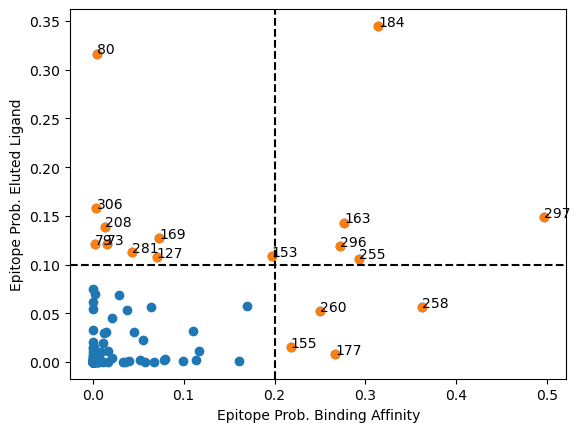

Core_Pos,73,79,80,127,153,155,163,169,177,184,208,255,258,260,281,296,297,306
EL,0.120766,0.120658,0.316698,0.107476,0.108595,0.015601,0.143075,0.127202,0.008407,0.345047,0.139048,0.106116,0.056741,0.052394,0.112531,0.119063,0.148620,0.157581
BA,0.015655,0.001888,0.004599,0.070428,0.196662,0.217833,0.276782,0.072974,0.266982,0.314312,0.013797,0.292430,0.361918,0.249750,0.043608,0.271970,0.496257,0.004031


In [5]:
tepi_EL = scorefxns['netMHCIIpan_EL']
tepi_BA = scorefxns['netMHCIIpan_BA']
wt_tepi = pd.DataFrame(
    [tepi_EL.epitope_scores_P_wt, tepi_BA.epitope_scores_P_wt],
    index=['EL','BA']).T

filt = wt_tepi[wt_tepi.EL.ge(0.10) | wt_tepi.BA.ge(0.20)]
plt.scatter(wt_tepi.loc['DRB1']['BA'], wt_tepi.loc['DRB1']['EL'])
plt.scatter(filt.loc['DRB1']['BA'], filt.loc['DRB1']['EL'])
for pos, row in filt.loc['DRB1'].iterrows():
    plt.text(row['BA'], row['EL'], pos)

plt.gca().axhline(0.10, c='k', ls='--')
plt.gca().axvline(0.20, c='k', ls='--')
plt.gca().set_xlabel('Epitope Prob. Binding Affinity')
plt.gca().set_ylabel('Epitope Prob. Eluted Ligand')
plt.show()

filt.loc['DRB1'].T.style.background_gradient(cmap='Blues',axis=1)

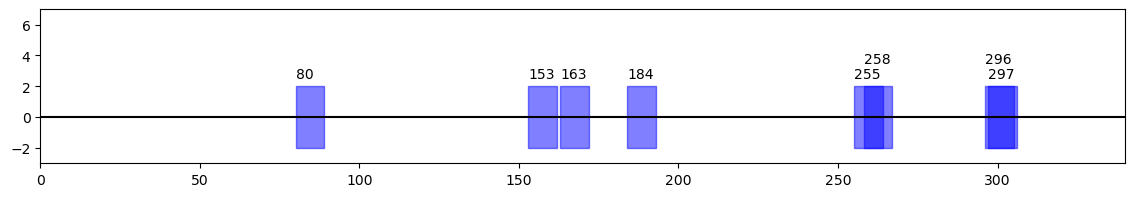

In [6]:
TARGETED_EPITOPES = {184:1.0, 80:1.0, 297:1.0, 163:1.0, 255:1.0, 153:1.0, 258:0.25, 296:0.25}

plt.axhline(0, c='k')
i = 0
for c in TARGETED_EPITOPES.keys():
    rect = patches.Rectangle((c, -2), 9, 4, linewidth=1, edgecolor='b', facecolor='b', alpha=0.5)
    plt.text(c,2.5+(c%2==0)*(c>250),str(c))
    plt.gca().add_patch(rect)
    i += 1
    
plt.gcf().set_size_inches(14,2)
plt.gca().set_ylim(-3,7)
plt.gca().set_xlim(0,340)

plt.show()

# Assemble function

### Interface

In [7]:
INTERFACE_7A = [
    66,67,68,84,85,86,88,90,91,92,93,94,95,96,97,98,127,128,129,
    130,132,133,134,135,155,156,158,159,160,161,162,163,164,165,
    166,167,168,169,170,171,172,173,174,179,184,185,186,187,188,
    189,190,191,192,195,197,198,199,200,201,202,203,204,205,224,
    228,251,252,253,254,255,256,257,258,259,260,261,262,263,264,
    280,282,284,285,286,287,288,290,291,294,295,296,297,301,307,
    308,309,310,311,313,314,315,316,317,318,319,320,321,322,323,
    324,326
]


### Scorefxn - Epitope avoidance

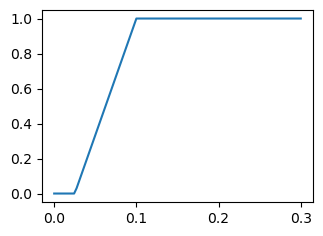

In [8]:
P_INCREASE_CUTOFF = 0.025
P_CEIL_CUTOFF = 0.10

def relu(x,x0=0):
    xc = x-x0
    return xc*(xc>0)

x = np.linspace(0,0.30,100)
f = lambda x: np.minimum(
    (1/(P_CEIL_CUTOFF-P_INCREASE_CUTOFF))*relu(x,P_INCREASE_CUTOFF), 1.0)
y = f(x)

plt.subplots(figsize=(3.5,2.5))
plt.plot(x,y)
plt.show()


In [9]:
WT_P = tepi_EL.predict(tepi_EL.target_seq, tepi_EL.seq_offset, per_epitope=True)
print(WT_P.shape)
P_INCREASE_CUTOFF = 0.025
P_CEILING_CUTOFF = 0.10

def introduced_epitopes(model,seq,i0):
    '''score should penalize increases in probability'''
    # Predict epitope probabilities in target seq
    _ = model.predict_mutscan(seq,i0)
    
    # Current score of seq: penalize where P > WT_P + cutoff
    Pseq_vs_wt_full = model.P_seq_epitopes - WT_P
    Pseq_vs_wt_epi = np.sum(model.gene_weights[:,np.newaxis] * Pseq_vs_wt_full, axis=0)
    score_seq_epi = np.minimum(
        (1/(P_CEILING_CUTOFF-P_INCREASE_CUTOFF))*relu(Pseq_vs_wt_epi,P_INCREASE_CUTOFF),
        1.0)
    score_seq = np.sum(score_seq_epi, axis=0)
    
    # Repeat for single mutations
    ## for each variant [L,AA] vector [genes,epitopes], subtract vs WT vector [genes,epitopes]
    Psmm_vs_wt_full = model.P_smm_epitopes - WT_P[:,:,np.newaxis,np.newaxis]
    # Weight and total by gene, result = [epitopes,L,AA]
    Psmm_vs_wt_epi = np.sum(model.gene_weights[:,np.newaxis,np.newaxis,np.newaxis] * \
                 Psmm_vs_wt_full, axis=0)
    # Increase penalty score if increase > cutoff for ANY epitope
    score_smm_epi = np.minimum(
        (1/(P_CEILING_CUTOFF-P_INCREASE_CUTOFF))*relu(Psmm_vs_wt_epi,P_INCREASE_CUTOFF),
        1.0) # [epitopes,L,AA]
    # Total across epitopes
    score_smm = np.sum(score_smm_epi, axis=0) # [L,AA]
    
    # Delta
    delta_score = score_smm - score_seq
    
    return delta_score

(3, 283)


### Scorefxn - Chemical liab elimination, and avoidance

In [10]:
# we want to avoid creating chem liabilities globally
cliab_model = scorefxns['2AU1_chem_liabilities']
cliab_model.predict_mutscan(job_data['target_seq'], job_data['index1'])
WT_CQAs = cliab_model.x_pred_i
FXN_SITES = np.array([i in (INTERFACE_7A) for i in cliab_model.idx_i])

LIAB_SITES = {}
for k in ['N-glycosylation','RGD','DP_clipping']:
    LIAB_SITES[k] = cliab_model.idx_i
for k in ['deamidation','oxidation','isomerization']:
    LIAB_SITES[k] = FXN_SITES

NO_LIAB = {}
for i,k in enumerate(cliab_model.idx_liabilities):
    NO_LIAB[k] = cliab_model.idx_i[WT_CQAs[i]==0]

    
def eliminate_CQAs(model, seq, i0):
    '''remove liabilities, particularly at functional sites'''
    smm = model.predict_mutscan(seq, i0, include_sites=LIAB_SITES)
    return smm
    
def avoid_CQAs(model, seq, i0):
    '''prevent introduction of any new liabilities'''
    smm = model.predict_mutscan(seq, i0, include_sites=NO_LIAB)
    return smm


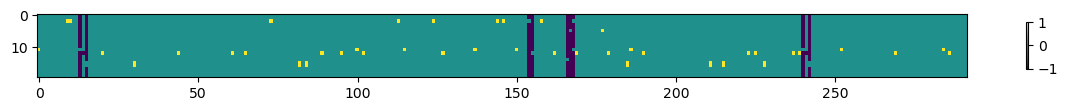

In [11]:
A = eliminate_CQAs(cliab_model, job_data['target_seq'], job_data['index1'])
cm = plt.imshow(A.T,
           interpolation='none');
plt.colorbar(cm, shrink=0.2)
plt.gcf().set_size_inches(15,3)
plt.show()

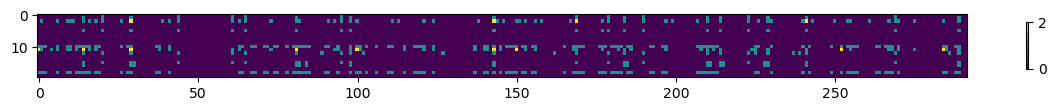

In [12]:
B = avoid_CQAs(cliab_model, job_data['target_seq'], job_data['index1'])
cm = plt.imshow(B.T,
           interpolation='none');
plt.colorbar(cm, shrink=0.2)
plt.gcf().set_size_inches(15,3)
plt.show()

# Simulated annealing run for the bitscore 0.6 model (other models are similar)

To prepare for simulated annealing, all scoring objects (loaded above) are incorporated into one multi-score object "multi". <br><br>
The multi-score object is provided with any mathematical transformations (argument "xform") that should be applied to raw scores generated by the scoring objects. e.g.
- Transform tepi raw scores to sum over targeted epitopes only (imm_remove).
- Transform tepi raw scores to penalize increases in epitope score globally while ignoring decreases (imm_avoid).
- Transform cliab to sum over targeted liabilities only (cm_remove).
- Transform cliab to penalize increases in liabilities globally while ignoring decreases (cm_avoid)
<br>


At this step, we also compute suggested weights that scale the scores relative to the fitness score ("evh_p95" .. "evh_p50").

For the rest of this notebook we use the term "chemical modification" (cm) in place of "chemical liability".

In [13]:
EVH_NAME = 'evh_b0.60_msc70_mcc50'
evh_model = scorefxns[EVH_NAME]

evh_p95 = np.percentile(evh_model.predict_mutscan().flatten(),95)
evh_p85 = np.percentile(evh_model.predict_mutscan().flatten(),85)
evh_p66 = np.percentile(evh_model.predict_mutscan().flatten(),66)
evh_p50 = np.percentile(evh_model.predict_mutscan().flatten(),50)

SAFETY_CUTOFF = evh_p66
UTILITY_GAIN = evh_p95 - evh_p85
VIOLATION_PENALTY = evh_p95 - evh_p50

MIN_DIST=10
MAX_DIST=12

print(evh_p95, evh_p85, evh_p50)
print('Safety cutoff', SAFETY_CUTOFF)
print('Approx. value added for desired effects', UTILITY_GAIN)
print('Approx. value penalized for violations', VIOLATION_PENALTY)


def dist_penalty(h, min_dist, max_dist):
    if np.min(h) >= max_dist:  return (h-max_dist)
    if np.max(h) <= min_dist:  return (min_dist-h)
    else:  return h*0
    
def safetynet(model,seq,i0):
    x = model.seq_to_mat(seq,i0)
    score_smm = model.smm <= SAFETY_CUTOFF
    delta_score_smm = score_smm - np.sum(score_smm*x, axis=-1)[:,np.newaxis]
    return delta_score_smm


multi = MultiScore(job_data['target_seq'], job_data['index1'])

# Evolutionary fitness
multi.add_scorefxn(evh_model, 'evh', weight=1)

# Chemical liabilities
multi.add_scorefxn(scorefxns['2AU1_chem_liabilities'], 'cm_remove', weight=-2,
                   xform = eliminate_CQAs)
multi.add_scorefxn(scorefxns['2AU1_chem_liabilities'], 'cm_avoid', weight=-2,
                   xform = avoid_CQAs)

# Remove selected T epitopes
scorefxns['netMHCIIpan_EL_W'] = deepcopy(scorefxns['netMHCIIpan_EL'])
scorefxns['netMHCIIpan_EL_W'].set_epitope_weights(TARGETED_EPITOPES)
multi.add_scorefxn(scorefxns['netMHCIIpan_EL_W'], 'imm_remove', weight=-20)

# Prevent T epitope gain
multi.add_scorefxn(scorefxns['netMHCIIpan_EL'], 'imm_avoid', weight=-40,
                   xform = introduced_epitopes)

# Specify distance from target sequence
scorefxns['seqdist'] = SeqDist(job_data['target_seq'], job_data['index1'])
multi.add_scorefxn(scorefxns['seqdist'], 'dist', weight=-10,
                   xform=lambda model,seq,io: dist_penalty(
                          model.predict_mutscan(seq,io), MIN_DIST, MAX_DIST))

# Avoid mutations with very low scores in wildtype
evh_model.target_seq = job_data['target_seq']
scorefxns['wt_delta_evh'] = TargetSeqEffect(evh_model)
multi.add_scorefxn(scorefxns['wt_delta_evh'], 'lowfit_avoid',
                   weight=-100, xform=safetynet)

weight_map = {
    'evh': 1,
    'cm_remove':        -np.around(UTILITY_GAIN/1,0),
    'cm_avoid':  -np.around(UTILITY_GAIN/1,0),
    'imm_remove':     -np.around(UTILITY_GAIN/0.15,0),    # ~ -2 evh : - 0.15 Tepi
    'imm_avoid':      -np.around(VIOLATION_PENALTY/1.0,0), # ~ -5 evh : + >0.10 Tepi
    'dist': -10,
    'lowfit_avoid': -100
}
print('utility boost:  \t', UTILITY_GAIN)
print('violation penalty:\t', VIOLATION_PENALTY)
print(weight_map)

multi.scorefxn_weights = weight_map
multi._precompute_mapping(weight_map=weight_map)

annlr = MultiAnnealer(multi)

0.0 -2.0471692833647483 -5.127437779590764
Safety cutoff -3.678220796179266
Approx. value added for desired effects 2.0471692833647483
Approx. value penalized for violations 5.127437779590764
utility boost:  	 2.0471692833647483
violation penalty:	 5.127437779590764
{'evh': 1, 'cm_remove': -2.0, 'cm_avoid': -2.0, 'imm_remove': -14.0, 'imm_avoid': -5.0, 'dist': -10, 'lowfit_avoid': -100}
out of 292 target sequence positions
292 / 292  sequence match for model evh
292 / 292  sequence match for model cm_remove
292 / 292  sequence match for model cm_avoid
292 / 292  sequence match for model imm_remove
292 / 292  sequence match for model imm_avoid
292 / 292  sequence match for model dist
292 / 292  sequence match for model lowfit_avoid


### Examine mutation options for chemical modification sites

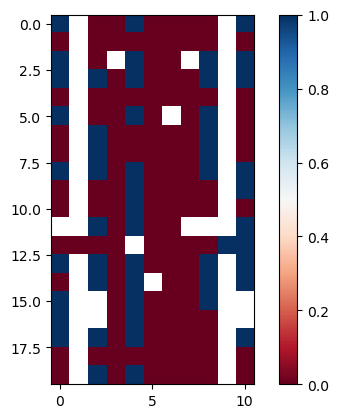

In [14]:
# white = does not remove chemical modification (cm)
# red = removes cm with costly fitness score
# blue = removes cm with acceptable fitness score
A = multi.aligned_scores[multi.names=='cm_remove']
B = multi.aligned_scores[multi.names=='evh']
B = deepcopy(1.0*(B > SAFETY_CUTOFF))
B[A>=0] = np.nan

cm = plt.imshow(B[:,np.any(A[0]<0,axis=1),:][0].T, cmap='RdBu')
plt.colorbar(cm);
plt.show()

### Examine contributions from all score functions

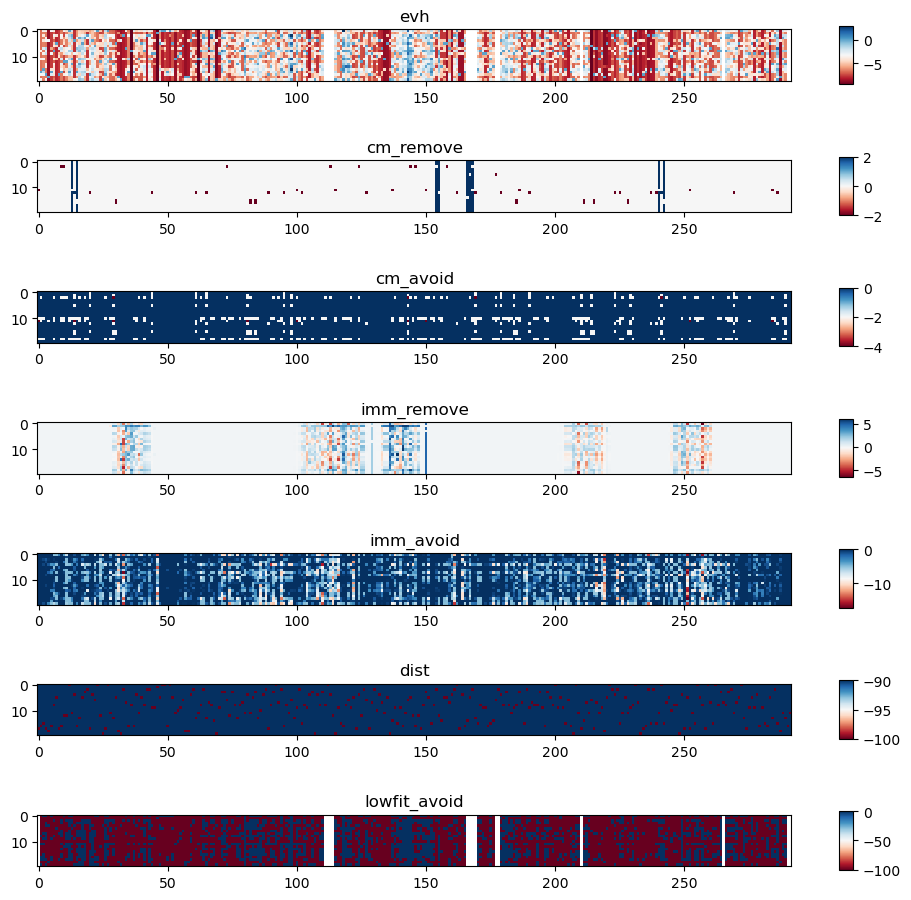

In [15]:
annlr.visualize_mats()
plt.show()

## Save out single mutation effect predictions for the wildtype

The multiscore object can output a mutation effect table by ".mat_to_table". 
- The tabled scores are those that result from the custom transformations provided.

In [16]:
_smm = multi.mat_to_table()
print(_smm.shape)
_smm.head()

(5840, 19)


,i,aa_wt,aa_mut,mut,multiscore,evh,cm_remove,cm_avoid,imm_remove,imm_avoid,dist,lowfit_avoid,evhxW,cm_removexW,cm_avoidxW,imm_removexW,imm_avoidxW,distxW,lowfit_avoidxW
0,48,V,A,V48A,NaN,NaN,0.0,0.0,0.0,0.0,9.0,NaN,NaN,-0.0,-0.0,-0.0,-0.0,-90.0,NaN
1,49,T,A,T49A,-196.684069,-6.684069,0.0,0.0,0.0,0.0,9.0,1.0,-6.684069,-0.0,-0.0,-0.0,-0.0,-90.0,-100.0
2,50,S,A,S50A,-93.661751,-3.661751,0.0,0.0,0.0,0.0,9.0,0.0,-3.661751,-0.0,-0.0,-0.0,-0.0,-90.0,-0.0
3,51,V,A,V51A,-93.648197,-3.648197,0.0,0.0,0.0,0.0,9.0,0.0,-3.648197,-0.0,-0.0,-0.0,-0.0,-90.0,-0.0
4,52,W,A,W52A,-198.660921,-8.660921,0.0,0.0,0.0,0.0,9.0,1.0,-8.660921,-0.0,-0.0,-0.0,-0.0,-90.0,-100.0


To create a score table with raw scores as appear in *Supplementary Table 1*:
- We require the raw output of the individual score functions, prior to annealer transformations.
- Use ".mat_to_table" to convert raw score matrices into easy-to-read single mutation tables.

In [17]:
smm = multi.mat_to_table(
).rename(columns={'evh':'delta_evh', 'imm_remove':'delta_T_target'})

tepi_smm = multi.mat_to_table(
    smm = tepi_EL.predict_mutscan()
).rename(columns={'multiscore':'delta_T_all'})
smm['delta_T_all'] = tepi_smm.delta_T_all

cl = scorefxns['2AU1_chem_liabilities']
cl_smm = multi.mat_to_table(
    smm = cl.predict_mutscan()
).rename(columns={'multiscore':'delta_CL'})
smm['delta_CL'] = cl_smm.delta_CL

cl_df = cl.mat_to_table()
for k in ['liabilities','overlaps_motif','sasa','sasa_rel','ss']:
    d = cl_df.set_index('i')[k]
    smm[k] = smm.i.map(d)

smm = smm.loc[:,[
'aa_wt','i','aa_mut','mut','delta_evh','delta_T_all','delta_T_target','delta_CL',
'liabilities','overlaps_motif','sasa','sasa_rel','ss'
]]

print(smm.shape)
smm.head()

(5840, 13)


,aa_wt,i,aa_mut,mut,delta_evh,delta_T_all,delta_T_target,delta_CL,liabilities,overlaps_motif,sasa,sasa_rel,ss
0,V,48,A,V48A,NaN,-0.000067,0.0,0.0,,,126.871561,0.768919,C
1,T,49,A,T49A,-6.684069,-0.007996,0.0,0.0,,,84.481134,0.518289,P
2,S,50,A,S50A,-3.661751,-0.004858,0.0,0.0,,,59.154933,0.413671,E
3,V,51,A,V51A,-3.648197,0.009039,0.0,0.0,,,26.567821,0.161017,E
4,W,52,A,W52A,-8.660921,-0.044270,0.0,-1.0,oxidation,52W,41.793776,0.158310,E


In [18]:
!mkdir outputs
smm.to_csv('./outputs/single_mutation_matrix.csv', index=False)

## Run simulated annealing - for best results, more iterations are recommended

In [19]:
L = len(IdeS)
TCYCLE = [1.0]*int(1.5*L) + [0.5]*int(1.5*L) + [0.10]*int(0.75*L) # CUSTOMIZE Temperature cycle

In [20]:
timestamp_str = datetime.now().strftime("%Y-%m-%d_%H%M%S") # unique ID for this design trajectory
annlr.Run(TCYCLE)

100%|██████████| 1095/1095 [02:11<00:00,  8.32it/s]


save_trajectory computes the full sequence score for the sequence at each iteration of annealing. <br><br>
A plot is produced to show the progress of all scores throughout the trajectory.
- See that evh increases while penalized scores (CM, IMM) decrease.

evh
cm_remove
cm_avoid
imm_remove
imm_avoid
dist
lowfit_avoid


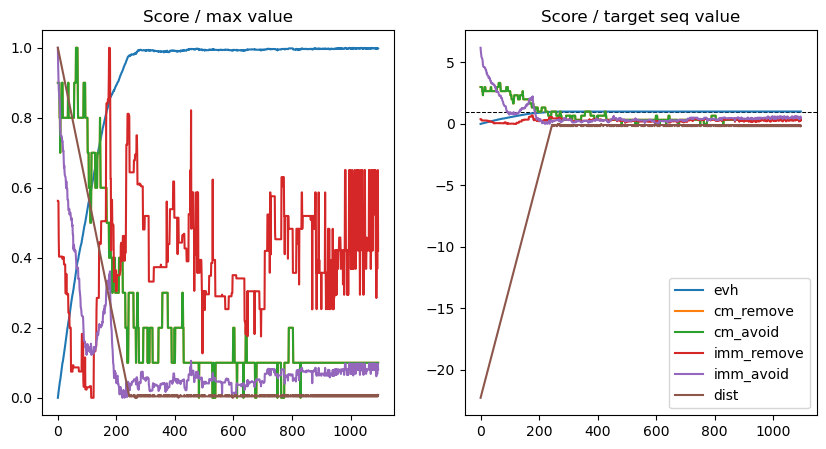

In [21]:
traj = annlr.save_trajectory()
plt.show()

In [26]:
annlr.traj_df

,mut,seq,P_mut,P_avg,evh,cm_remove,cm_avoid,imm_remove,imm_avoid,dist
0,Y315E,VAGEQNNFYSCKVNNWDVPCPACVVVNANTCPTWRLCQFNLCGSWM...,0.019180,0.000171,14.530515,18.0,18.0,0.875151,11.828222,256
1,A94C,VAGEQNNFYSCKVNNWDVPCPACVVVNANTCPTWRLCQFNLCGSWM...,0.993102,0.000171,23.624215,18.0,18.0,0.875151,11.449029,255
2,L267W,VAGEQNNFYSCKVNNWDVPCPACVVVNANTCPTWRLCQFNLCGSWM...,0.376433,0.000171,32.221227,18.0,18.0,0.872741,11.226413,254
3,R304G,VAGEQNNFYSCKVNNWDVPCPACVVVNANTCPTWRLCQFNLCGSWM...,0.770422,0.000171,38.670547,18.0,18.0,0.782357,10.967027,253
4,W81D,VAGEQNNFYSCKVNNWDVPCPACVVVNANTCPTDRLCQFNLCGSWM...,0.044879,0.000171,46.829923,18.0,18.0,0.738037,10.873435,252
...,...,...,...,...,...,...,...,...,...,...
1090,H191A,VTSVWTKGVTPPAQFTQGEDVFHAPYVANQGWYDITKTFNGKDDLL...,0.817735,0.000171,1168.756664,10.0,10.0,0.753319,5.119722,13
1091,A191H,VTSVWTKGVTPPAQFTQGEDVFHAPYVANQGWYDITKTFNGKDDLL...,0.158504,0.000171,1166.963872,10.0,10.0,0.707842,5.029051,12
1092,H191A,VTSVWTKGVTPPAQFTQGEDVFHAPYVANQGWYDITKTFNGKDDLL...,0.817735,0.000171,1168.756664,10.0,10.0,0.753319,5.119722,13
1093,N297F,VTSVWTKGVTPPAQFTQGEDVFHAPYVANQGWYDITKTFNGKDDLL...,0.319309,0.000171,1169.877687,10.0,10.0,0.950752,5.242365,12


In [25]:
# save the final design
annlr.traj_df.tail(1).iloc[:,1:].to_csv(f'./outputs/sampled_design_{timestamp_str}.csv')
annlr.traj_df.tail(1).iloc[:,1:]

,seq,P_mut,P_avg,evh,cm_remove,cm_avoid,imm_remove,imm_avoid,dist
1094,VTSVWTKGVTPPAQFTQGEDVFHAPYVANQGWYDITKTFNGKDDLL...,0.652922,0.000171,1168.756664,10.0,10.0,0.753319,5.119722,13


### Inspect the results of annealing

visualize_design returns two plots that describe the final design:
- For each score, all mutations in the final design are plotted to show their impact on that score (y-axis) versus their impact on fitness (x-axis).
    - most mutations have positive fitness, and those with negative fitness serve to decrease CM or IMM.
- A comparison of predicted T cell epitope in the final design (blue) versus the wildtype sequence (orange).
    - There is a net reduction in predicted T cell epitopes (removal of orange peaks).

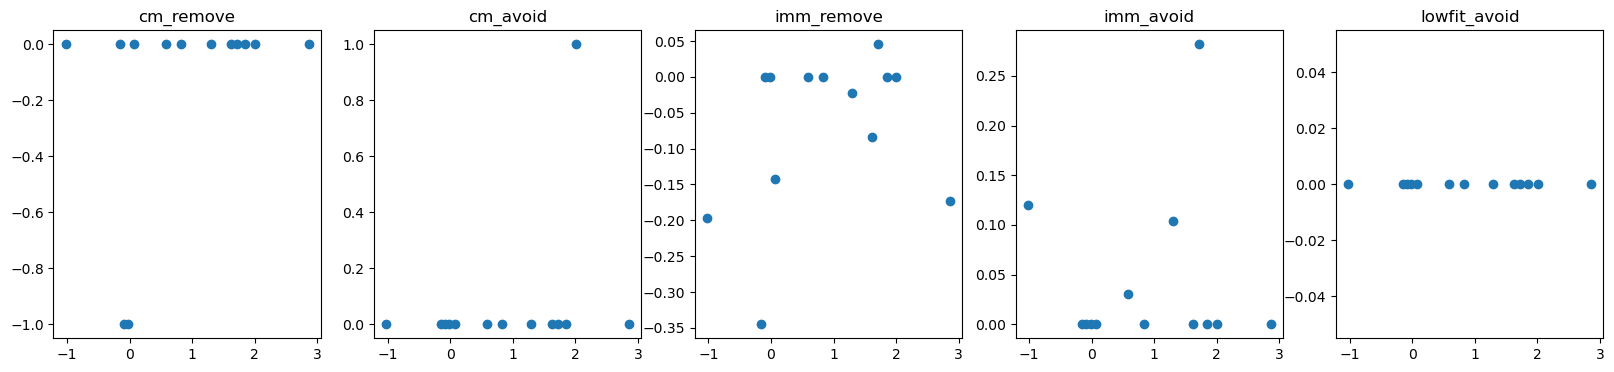

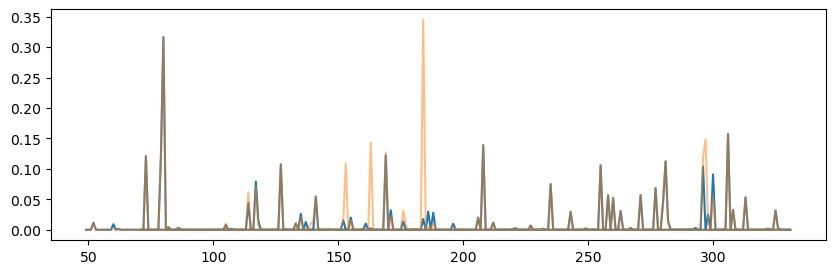

In [27]:
annlr.visualize_design(
    traj.seq.iloc[-1],
    annlr.Score.uniprot_index,
    tepi_name='imm_remove',
    #evh_name='evh',
    #dist_name='dist'
)
plt.show()

### Re-run with different design goals 

Above we ran a single trajectory that optimizes for all modeled drug properties. <br><br>

To generate sequences that optimizes for only a subset of drug properties, set the corresponding weights to zero (cell below) and run a new annealing trajectory (return to cell above).

In [28]:
# to generate sequences without accounting for chemical modifications
# annlr.Score.scorefxn_weights['cm_remove'] = 0
# annlr.Score.scorefxn_weights['cm_avoid'] = 0

# to generate sequences without accounting for t cell epitopes
# annlr.Score.scorefxn_weights['imm_remove'] = 0
# annlr.Score.scorefxn_weights['imm_avoid'] = 0

# update weights vector
annlr.Score.w = np.array(annlr.Score.scorefxn_weights.values())

# inspect weight choices
annlr.Score.scorefxn_weights

{'evh': 1,
 'cm_remove': -2.0,
 'cm_avoid': -2.0,
 'imm_remove': -14.0,
 'imm_avoid': -5.0,
 'dist': -10,
 'lowfit_avoid': -100}